**Educational Attainment and Success**


---


Chieh-Huang Chen \
Melvin Cherian \
Michael LI \


---

Course: CSC 59970 - Introduction to Data Science \
Instructor: Grant M. Long
Project



**Goals for this Project**

1.  Apply Python to load, clean, and process data sets.
2.  Identify key patterns in a data set using computational analysis and statistical methods.
3.  Apply principles of statistical modeling and machine learning to data.
4.  Effectively explain, visualize, and communicate empirical findings.


---

**Our Questions**


*   What human development indicators strongly correlate with adult education level in countries?
*   What are significant factors from each major category from the human development dataset that determines adult education level in countries?
*   Which countries have a strong potential in increasing their education level within the next five years?

---

*Thoughts from Chieh (Remove this before submitting the final project)*

1. Use the dataset and find potential indicators that have high coorelations with Education Index (https://en.wikipedia.org/wiki/Education_Index), which is used to judge each countries' education level based on the number of years a child is expected to attend school or university and the average number of years of education received by people ages 25 and older.

2.  Find the potential indicators for each country and use those potential indicators to predict education index through linear regression.

3. Assumptions of Linear Regression \
a.  Data is linear in form. \
b.  Sample is random. \
c.  Error terms have constant variance (homoscedasticity). \
d.  Error terms have a mean of zero based on the observed data. \
e.  Predictors are independent (no multicollinearity). \
f.   Errors are normally distributed. \

4. How to satisfy these assumptions from #3? \
a. Check if the correlation of determination is greater than 0.7  \
b. The data that we collected represents the consenus of the entire country. \
c. There's a constant variance because it's yearly. \
d. Get the standard error of the array and see if it is similar. \
e. Use an algorithm to remove coorelations between predictors. \
f. Yes it is. \

---

*Thoughts from Melvin (Remove this before submitting the final project)*


---

*Thoughts from Michael (Remove this before submitting the final project)*

---





*Libraries*


*   Numpy
*   Pandas
*   Matplotlib



In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

*Loading Data into Memory*

---

We loaded two datasets into memory: Adult Education Level (AEL) dataset and Human Development Indicators (HDI) dataset.

We specifically removed column 9999 from our dataset because it only shows the latest value from the data drawn within 1990 to 2017. In this analysis, we analyzed these indicators over time to predict the future of education level in each country.

In [2]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'
education_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/adult_education_level.csv'

inds_df = pd.read_csv(indicators_url)
ed_df = pd.read_csv(education_url)

inds_df = inds_df.drop(columns=['9999'])

Many of our HDIs only have zero or one recordings in the dataset in years between 1990 to 2017. Due to the lack of data over time, we decided to remove these indicators that has at most 2 data points in each row.

When we removed these indicators, it cleans up at least 28% of the HDI dataset.

In [3]:
threshold = 2
drop_stack = set()
length_before = len(inds_df)
print("Number of rows in the indicators data frame before the cleanup:", length_before)
for index, row in inds_df.iterrows():
    if row['1990':].count() <= threshold:
        drop_stack.add(index)

inds_df = inds_df.drop(drop_stack)
length_after = len(inds_df)
print("Number of rows in the indicators data frame after the cleanup:", length_after)
print("% of rows deleted: {0:.2f}%".format((length_before - length_after) * 100 / length_after))


Number of rows in the indicators data frame before the cleanup: 25636
Number of rows in the indicators data frame after the cleanup: 19911
% of rows deleted: 28.75%


*Plotting Correlations for each country*

We have a method to retrieve each indicators for a country we specify for future uses.

In [4]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
  
def plot_corr_country(df, country):
  # drop ids etc., get only rows with country, transpose
  df_corr = inds_df.drop(df.columns[[0, 1, 3]], axis=1)[df.country_name == country].T
  # fix columns
  df_corr.columns = df_corr.iloc[0]
  # drop first two rops
  df_corr = df_corr[2:]
  # df_corr = inds_df.drop(inds_df.columns[[0, 1, 3]], axis=1).drop(inds_df.columns[range(5,32)], axis=1)[inds_df.country_name == "Albania"]
  df_corr = df_corr.apply(pd.to_numeric)
#   plot_corr(df_corr, size=20)
  return df_corr

### How do we determine the strongest indicators to Education Index for each country?

**Education Index:** A standard created by United Nations that determines educational attainment for each country. \
**Formula:** MYSI + EYSI / 2 \
Mean Years of Schooling Index(MYSI): MYS / 15 \
Mean Years of Schooling(MYS): Average number of years of education received by people ages 25 and older. \
Expected Years of Schooling Index(EYSI): EYS / 18 \
Expected Years of Schooling(EYS): The number of years a child is expected to attend school, or university, including the years spent on repetition. \

*Source: https://en.wikipedia.org/wiki/Education_Index* 



---


We get the strongest correlations for each country by getting the correlation coefficient between the Education Index to every other indicator in the row for that country. By squaring the correlation coefficient, we get the correlation of determination (R^2) which tells us the percentage of the variance in our dependent variable that can be explained by our independent variable. In this case, we sorted the indicators based on the correlation of determination and remove all the indicators where its correlation of determination to the Education Index is less than 0.7.

We then dropped the indicators that are directly dependent to the Education Index based on the formula such as 'Education index', 'Expected years of schooling (years)' and 'Mean years of schooling (years)'.

In [5]:
# Get the strongest indicators towards the Education Index by getting the strongest correlation of determination (R^2)
# between every other indicators to the Education Index. 
def get_strongest_correlations(df_corr, indicator, num_indicators = 100, threshold=0.7):
    correlations = []
    for row in df_corr.corr():
        corr_determ = df_corr.corr()[row][indicator] ** 2
        if corr_determ >= threshold:
          correlations.append([row, corr_determ])
    
    correlations.sort(key = lambda corr: corr[1], reverse=True)
    return correlations[:num_indicators]

*Grouping Indicators Based on Categories* \
The methods below groups these indicators to categories found in the dataset. The dataset we used have categorized closely related indicators and by taking advantage of these categories, we can assume that the indicators are not multicollinear because their dependences of these indicators aren't closely related with each other based on context of these indicators.

In [6]:
# Map indicators to categories
def map_ind_to_categories(df):
  ind_map = {}
  mapped_inds = df.groupby(['dimension', 'indicator_name']).size().reset_index().rename(columns={0:'count'})
  for index, row in mapped_inds.iterrows():
    ind_map[row['indicator_name']] = row['dimension']
  return ind_map

def group_indicators(df, potential_indicators):
  ind_map = map_ind_to_categories(df)
  groups = {}
  features = []
  for p in potential_indicators:
    if ind_map[p[0]] not in groups:
      groups[ind_map[p[0]]] = [p]
    else:
      groups[ind_map[p[0]]].append(p)
  for g in groups:
    features.append(max(groups[g], key=lambda g: g[1])[0])
  return features

*Selecting our Indicators for Modeling Purposes* \
In our model in predicting Education Index for each country, we selected one indicator from each category as our predictors for country. These indicators that we've chosen will not be collinear with each other under the assumption that these indicators are only closely related with the categories that they belong in the dataset.

In [7]:
# Get potential indicators from countries
def get_potential_indicators(df, country, target, ignored_features=[], grouped=True):
  country_df = plot_corr_country(df, country)
  if target not in country_df:
#     print("{} does not have an {}".format(country, target))
    return []
  potential_indicators = get_strongest_correlations(country_df, target)
  potential_indicators = [p for p in potential_indicators if p[0] not in ignored_features]
  features = [p[0] for p in potential_indicators] 
  if grouped:
    features = group_indicators(df, potential_indicators)
  return features


*Retrieving our Potential Indicators for Each Country* \
We then retrieve all the indicators that we will be using for each country based on our explanation from above. Note that there are some countries that does not have an Education Index (e.g. North Korea) due to a lack of information.

In [21]:
# Dropping 'Education index', 'Expected years of schooling (years)', 
# 'Mean years of schooling (years)' and others 
# because they are part of the Education Index formula
dep_ed_ind = [ 'Human Development Index (HDI)', 
               'Human Development Index (HDI), female', 
               'Human Development Index (HDI), male', 
               'Education index', 
               'Expected years of schooling (years)', 
               'Mean years of schooling (years)', 
               'Expected years of schooling, female (years)', 
               'Mean years of schooling, female (years)',
               'Expected years of schooling, male (years)',
               'Expected years of schooling, male (years)',
               'Mean years of schooling, male (years)',
               'Inequality-adjusted education index'
              ]   

target = 'Education index'
country_indicators = {}
country_names = inds_df.country_name.unique()
for c in country_names:
  features = get_potential_indicators(inds_df, c, target, dep_ed_ind, False)
  if len(features) != 0:
    country_indicators[c] = features


*Taking a Look at Most Frequent Indicators for All Countries* \
Let's take a look at the indicators that pops up frequently in each countries. We counted all the indicators that popped up in all countries and ranked them based on their number of appearances.

In [9]:
top_indicators = {}
for c in country_indicators:
  for ind in country_indicators[c]:
    if ind in top_indicators:
      top_indicators[ind] += 1
    else:
      top_indicators[ind] = 1
sorted_top_indicators = sorted(top_indicators.items(), key=lambda kv: kv[1], reverse=True)
print("Top Indicators Used for Each Country")
for i, ind in enumerate(sorted_top_indicators, 1):
  print("{}. {} \t Number of countries: {}".format(i, ind[0], ind[1]))

Top Indicators Used for Each Country
1. Human Development Index (HDI) 	 Number of countries: 177
2. Median age (years) 	 Number of countries: 162
3. Life expectancy at birth (years) 	 Number of countries: 161
4. Life expectancy index 	 Number of countries: 161
5. Mortality rate, infant (per 1,000 live births) 	 Number of countries: 157
6. Life expectancy at birth, female (years) 	 Number of countries: 155
7. Mortality rate, under-five (per 1,000 live births) 	 Number of countries: 155
8. Human Development Index (HDI), male 	 Number of countries: 155
9. Human Development Index (HDI), female 	 Number of countries: 154
10. Life expectancy at birth, male (years) 	 Number of countries: 153
11. Urban population (%) 	 Number of countries: 146
12. Gross domestic product (GDP), total (2011 PPP $ billions) 	 Number of countries: 142
13. Adolescent birth rate (births per 1,000 women ages 15-19) 	 Number of countries: 141
14. Internet users, total (% of population) 	 Number of countries: 140
15. Y

*Preprocessing Our Dataset In Preparation for Our Model* \
In our dataset, the data that we saw are transposed where the years and the values are columns. After transposing, we had an option to remove rows that have missing data. However, we chose to fill out the missing data using a linear regression model because the dataset we are currently used. We have provided a scatterplot for these indicators as reference in proving that the data is linear in form. Finally, we returned a dataset that will be used to predict our Education Index along with a collection of regressors that we've used to map years to our indicators. (NOTE: SCATTERPLOT MODEL NEEDED)

In [10]:
# Transpose the data frame to only have years and values as columns
def transpose_yearly_values(df):
  df = df.drop(columns=['dimension', 'indicator_id', 'iso3', 'country_name'])
  df = df.set_index('indicator_name').transpose()
  df['Year'] = pd.to_numeric(df.index)
  return df

# Predicting the missing values using Linear Regression Models
# and then filling out the missing values based on the model
# Preserve the Linear Regression for future uses
def build_regressors(inds_df, country, indicators):
  country_df = inds_df.loc[inds_df['country_name'] == country]
  reg_inds = {}
  filled_indicators = pd.DataFrame(data={'Year':pd.to_numeric(country_df.columns[5:].values)})
  for ind in indicators:
    ind_df = country_df.loc[country_df['indicator_name'] == ind]
    values_df = transpose_yearly_values(ind_df)
    
    # Get the missing values in each year and predict them later on.
    missing_years = values_df[values_df[ind].isnull()].Year.values
    values_df = values_df.dropna()
    
    # Fit the data to the Linear Regression and predict the values
    X = values_df['Year'].values.reshape(-1, 1)
    Y = values_df[ind].values.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(X, Y)
    
    # Filling out the missing data back to values_df
    if missing_years.size > 0:
      missing_years = missing_years.reshape(-1, 1)
      missing_values = reg.predict(missing_years)
      missing_years = missing_years.reshape(1, -1)[0]
      missing_values = missing_values.reshape(1, -1)[0]
      predicted_df = pd.DataFrame({'Year': missing_years, ind: missing_values})
      values_df = values_df.append(predicted_df, sort=False)
    # Preserve the filled out data and the regression for future uses
    reg_inds[ind] = reg
    filled_indicators = filled_indicators.merge(values_df, left_on='Year', right_on='Year')
  
  return reg_inds, filled_indicators


*Building our Models* \
In our final step, we built the multiple regression model by using our indicators as our predictors and our Education Index as our target.  Thoughts compare year vs education index vs our model

In [11]:
class EducationIndexModel:
  def __init__(self, target='Education index'):
    self.target = target
    self.reg_created = False
    
  def fit(self, inds_df, country, indicators):
    self.feature_regressors, self.features_df = build_regressors(inds_df, country, country_indicators[country])
    self.target_regressor, self.target_df = build_regressors(inds_df, country, [target])
    self.X = self.features_df.values
    self.Y = self.target_df[target].values
    self.reg = LinearRegression()
    self.reg.fit(self.X, self.Y)
    self.reg_created = True
    
  def predict_year(self, years):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    predictors_df = pd.DataFrame({'Year': years})
    years = np.array([years]).reshape(-1, 1)
    for f in self.feature_regressors:
      f_vals = self.feature_regressors[f].predict(years)
      predictors_df[f] = f_vals.reshape(1, -1)[0]
    X_pred = predictors_df.values
    education_index = self.reg.predict(X_pred)
    return education_index
  
  
  def get_r_squared(self, adjusted=False):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    Yhat = self.reg.predict(self.X)
    SS_Residual = sum((self.Y-Yhat)**2)
    SS_Total = sum((self.Y-np.mean(self.Y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    if not adjusted:
      return r_squared
    else:
      adjusted_r_squared = 1 - (1-r_squared)*(len(self.Y)-1)/(len(self.Y)-self.X.shape[1]-1)
      return adjusted_r_squared
  
  # Training 75% of our dataset and testing it on the remaining 25%
  def get_mse_score(self, test_size=0.25):
    train_index = range(int(len(self.X) * (1 - test_size)))
    test_index = range(len(train_index), len(self.X))
    X_train, X_test = self.X[train_index], self.X[test_index]
    Y_train, Y_test = self.Y[train_index], self.Y[test_index]
    cv_reg = LinearRegression()
    cv_reg.fit(X_train, Y_train)
    Y_pred = cv_reg.predict(X_test)
    rmse = np.sqrt(sum((Y_test-Y_pred)**2)/len(Y_pred))
    return sum((Y_test - Y_pred)**2)/len(Y_pred)
    
  def get_r_squared_from_simple_reg(self):
    if not self.reg_created:
      print("Model not created")
      return None
    r2 = self.target_regressor[self.target].score(
        self.features_df['Year'].values.reshape(-1, 1),
        self.Y)
    return r2 
  
  def get_table_summary(self):
    if not self.reg_created:
      print("Model not created")
      return None
    model = sm.OLS(self.Y, self.X).fit()
    return model.summary()
  
  def get_table_summary_from_simple_reg(self):
    if not self.reg_created:
      print("Model not created")
      return None
    model = sm.OLS(self.Y, self.features_df['Year'].values.reshape(-1,1)).fit()
    return model.summary()

eim = EducationIndexModel()
country = 'Peru'
eim.fit(inds_df, country, country_indicators[country])
print(eim.predict_year(range(2020, 2025)))
print(eim.get_r_squared(adjusted=False))
print(eim.get_mse_score())
eim.get_r_squared_from_simple_reg()
print(eim.get_table_summary_from_simple_reg())
print(eim.get_table_summary())

[0.71806897 0.72331773 0.7285665  0.73381527 0.73906404]
1.0
0.010013466444817518
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     6012.
Date:                Tue, 14 May 2019   Prob (F-statistic):           2.90e-33
Time:                        19:50:25   Log-Likelihood:                 48.815
No. Observations:                  28   AIC:                            -95.63
Df Residuals:                      27   BIC:                            -94.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

/home/xubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/xubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/home/xubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/home/xubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [0]:
# https://medium.com/cindicator/backtesting-time-series-models-weekend-of-a-data-scientist-92079cc2c540


In [ ]:
def plot_indicators_vs_year(df, country):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    new_df = new_df[new_df.country_name == country]
    #Generating different colors
    number = len(new_df)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    color_index = 0
    while len(new_df) > 0:
        temp = new_df.iloc[0]
        print(temp["indicator_name"])
        x_vals = []
        y_vals = []
        for year in range(1990, 2017):
            if str(temp[str(year)]) != "nan":
                x_vals.append(year)
                y_vals.append(temp[str(year)])
        plt.xlabel("Years")
        plt.ylabel("Indicator Values")
        plt.scatter(x_vals, y_vals, color = colors[color_index], alpha = .7)
        new_df = new_df.iloc[1:,]
        if len(x_vals) > 0:
            fit = np.polyfit(x_vals, y_vals, 1)
            fit_fn = np.poly1d(fit)
            plt.plot(x_vals, fit_fn(x_vals), color=colors[color_index])
        color_index += 1

In [ ]:
def plot_vs_year(df, country):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    new_df = new_df[new_df.country_name == country]
    #Generating different colors
    number = len(new_df)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    color_index = 0
    while len(new_df) > 0:
        temp = new_df.iloc[0]
        #print(temp["indicator_name"])
        x_vals = []
        y_vals = []
        x_vals_percents = []
        y_vals_percents = []
        for year in range(1990, 2018):
            if "%" in temp["indicator_name"]:
                if str(temp[str(year)]) != "nan":
                    x_vals_percents.append(year)
                    y_vals_percents.append(temp[str(year)])
            else:
                if str(temp[str(year)]) != "nan":
                    x_vals.append(year)
                    y_vals.append(temp[str(year)])
        """if len(x_vals_percents) > 0:
            if int(y_vals_percents[-1]) < 0:
                print(temp['indicator_name'])"""
        plot_graphs_edu_idx(0, "Indicators vs year", "Years", "Indicator Values", x_vals, y_vals, colors, color_index)
        plot_graphs_edu_idx(1, "Indicators(%) vs year", "Years", "Indicator Values", x_vals_percents, y_vals_percents, colors, color_index)
        color_index += 1
        new_df = new_df.iloc[1:,]

In [ ]:
def plot_graphs_edu_idx(figure_num, title, x_label, y_label, x_vals, y_vals, colors, color_index):
    plt.figure(figure_num)
    #plt.rc('font', size=12)
    #plt.rc('axes', labelsize=12)
    #plt.rc('xtick', labelsize=12)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.scatter(x_vals, y_vals, color = colors[color_index], alpha = .7)
    """if len(x_vals) > 0 and max(y_vals) > 75:
        fit = np.polyfit(x_vals, y_vals, 1)
        fit_fn = np.poly1d(fit)
        plt.plot(x_vals, fit_fn(x_vals), color=colors[color_index])"""

In [ ]:
plot_vs_year(inds_df, "Afghanistan")

In [ ]:
def plot_indicator_count(df):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    indicators_count = {}
    for i in range(len(df)):
        if df["indicator_name"].iloc[i] not in indicators_count.keys():
            indicators_count[df["indicator_name"].iloc[i]] = 1
        else:
            indicators_count[df["indicator_name"].iloc[i]] += 1
    plt.figure(figsize=(100,50))
    y_vals = [indicators_count[key] for key in indicators_count.keys()]
    #print(y_vals)
    x_pos = [(3 * i) for i in np.arange(len(indicators_count.keys()))]
    plt.rc('font', size=100)
    #plt.rc('axes', labelsize=100)
    plt.rc('xtick', labelsize=50)
    #plt.rc('title', labelsize=100)
    plt.bar(x_pos, y_vals, align='center')
    plt.xticks(x_pos, indicators_count.keys(), rotation='vertical')
    plt.ylabel('Number of Countries')
    plt.title("Indicator Count")

In [ ]:
#plot_indicator_count(inds_df)
#plt.rc('font', size=12)
#plt.rc('axes', labelsize=12)
#plt.rc('xtick', labelsize=12)

In [14]:
def plot_top_indicators(top_indicators_vals):
    x_vals = []
    y_vals = []
    amount = 20
    for i in range(amount, -1, -1):
        x_vals.append(top_indicators_vals[i][0])
        y_vals.append(int(top_indicators_vals[i][1]))    
    plt.figure(figsize=(10,10))
    y_pos = np.arange(len(x_vals))
    plt.barh(y_pos, y_vals, align='center')
    plt.yticks(y_pos, x_vals)
    plt.xlabel('Number of Countries')
    plt.title("Highly-Correlated indicators to Education Index Frequency")

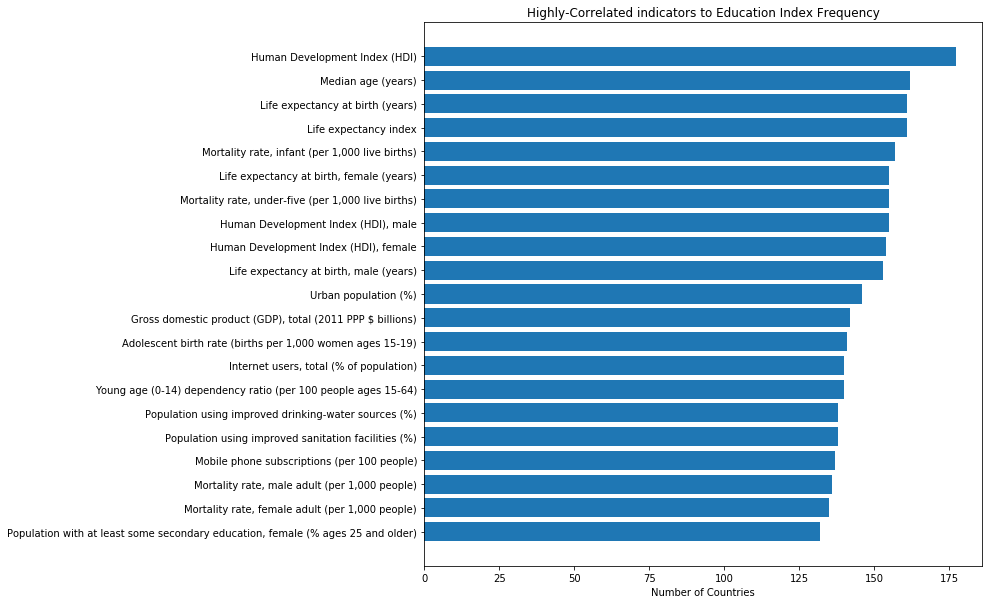

In [22]:
plot_top_indicators(sorted_top_indicators)

In [16]:
def plot_health(df, health_indep, target):
    health_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    #obtain rows that have the indicator matching health_indep and target respectively
    health_indicator_data = health_df[health_df.indicator_name == health_indep]
    education_index = health_df[health_df.indicator_name == target]
    #generate colors
    number = len(health_indicator_data)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    color_index = 0
    for i in range(len(health_indicator_data)):
        health_i = []
        education_i = []
        #finds the pairs by going across each country's row
        for j in range(1990, 2018):
            c_val = health_indicator_data["country_name"].iloc[i]
            #checks if country is in both sections and then add both to respective list
            if c_val in list(education_index["country_name"]):
                health_i.append(health_indicator_data[str(j)].iloc[i])
                education_i.append(education_index[education_index.country_name == c_val][str(j)].iloc[0])
                #if int(health_i[-1]) < 40:
                #    print(c_val)
        #plots each time a country is done
        plt.scatter(health_i, education_i, color = colors[color_index], alpha = .7)
        color_index += 1
    plt.xlabel(health_indep)
    plt.ylabel(target)
    #plt.scatter(health_i, education_i)
    #fit = np.polyfit(health_i, education_i, 1)
    #fit_fn = np.poly1d(fit)
    #plt.plot(health_i, fit_fn(health_i), color="red")

Graph of Life expectency vs Mean Years of Schooling.

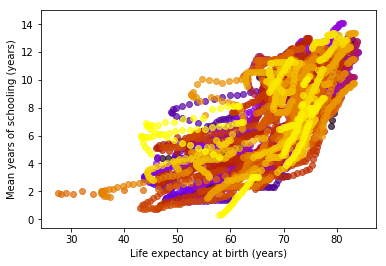

In [17]:
plot_health(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)")

In [18]:
def plot_country_life_vs_edu(df, health_indep, target, country):
    health_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    health_indicator_data = health_df[(health_df.indicator_name == health_indep) & (health_df.country_name == country)]
    education_index = health_df[(health_df.indicator_name == target) & (health_df.country_name == country)]
    health_i = []
    education_i = []
    for j in range(1990, 2018):
            c_val = health_indicator_data["country_name"].iloc[0]
            #checks if country is in both sections and then add both to respective list
            if c_val in list(education_index["country_name"]):
                health_i.append(health_indicator_data[str(j)].iloc[0])
                education_i.append(education_index[education_index.country_name == c_val][str(j)].iloc[0])
                #if int(health_i[-1]) < 40:
                #    print(c_val)
        #plots each time a country is done
    plt.scatter(health_i, education_i, alpha = .7)
    plt.xlabel(health_indep)
    plt.ylabel(target)
    plt.title(country)

In [19]:
def plot_pisa(df, type_score):
    #Retrieves the rows where the indicator is equal to the respective values
    life_expectancy = df[df.indicator_name == "Life expectancy at birth (years)"]
    pisa = df[df.indicator_name == "Programme for International Student Assessment (PISA) score in {}".format(type_score)]
    life_val = []
    pisa_val = []
    for i in range(len(life_expectancy)):
        c_val = life_expectancy["country_name"].iloc[i]
        #checks to see if both life_expectancy and pisa have this country entry 
        if c_val in list(pisa["country_name"]):
            life_val.append(life_expectancy["2015"].iloc[i])
            #picks out the pisa entry for that country for 2015
            pisa_val.append(pisa[pisa.country_name == c_val]["2015"].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Programme for International Student Assessment (PISA) score in {}".format(type_score))
    plt.scatter(life_val, pisa_val)
    fit = np.polyfit(life_val, pisa_val, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_val, fit_fn(life_val), color="red")

Plots of Life expectiancy vs 2015 Pisa scores

In [ ]:
plot_pisa(inds_df, "mathematics")

In [ ]:
plot_pisa(inds_df, "reading")

In [ ]:
plot_pisa(inds_df, "science")

In [ ]:
plot_country_life_vs_edu(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Rwanda")

In [ ]:
plot_country_life_vs_edu(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Sierra Leone")

In [14]:
def plot_indicator_vs_year(df, indicator, country):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    target_indicator = new_df[(new_df.indicator_name == indicator) & (new_df.country_name == country)]
    #print(target_indicator["1990"].iloc[0])
    year_i = []
    target_i = []
    for j in range(1990, 2018):
        year_i.append(j)
        target_i.append(target_indicator[str(j)].iloc[0])
        #if int(health_i[-1]) < 40:
        #   print(c_val)
        #plots each time a country is done
    plt.scatter(year_i, target_i, alpha = .7)
    plt.xlabel("year")
    plt.ylabel(indicator)
    plt.title(country)

In [41]:
def plot_education_index(df):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    new_df = new_df[new_df.indicator_name == "Education index"]
    countries = []
    for i in range(0, len(new_df)):
        countries.append(new_df["country_name"].iloc[i])
    #y_pos = np.arange(len(countries))
    #year_education_inds = []
    for year in range(1990, 2018):
        education_ind = []
        for i in range(0, len(new_df)):
            if str(new_df[str(year)].iloc[i]) == "nan":
                education_ind.append(0)
            else:
                education_ind.append(float(new_df[str(year)].iloc[i]))
        
        #year_education_inds.append(education_ind)
        edu_idx_list = [[countries[j], education_ind[j]] for j in range(len(countries))]
        edu_idx_list.sort(key=lambda x: x[1])
        top_x_vals = []
        top_y_vals = []
        indicator_num = 20
        for j in range(indicator_num):
            top_x_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][0])
            top_y_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][1])
        y_pos = np.arange(len(top_x_vals))
        plt.figure(figsize=(10,10))
        plt.barh(y_pos, top_y_vals, align='center', alpha=0.5)
        plt.yticks(y_pos, top_x_vals)
        plt.xlabel('Education index')
        plt.title("Countries with Highest Educational Attainment in {}".format(year))
    prediction_plot(countries, 2018, 2025)

/home/xubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


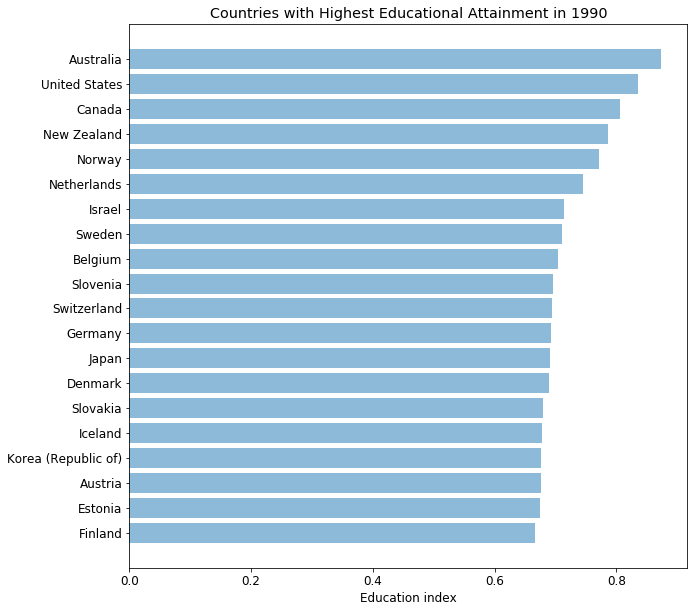

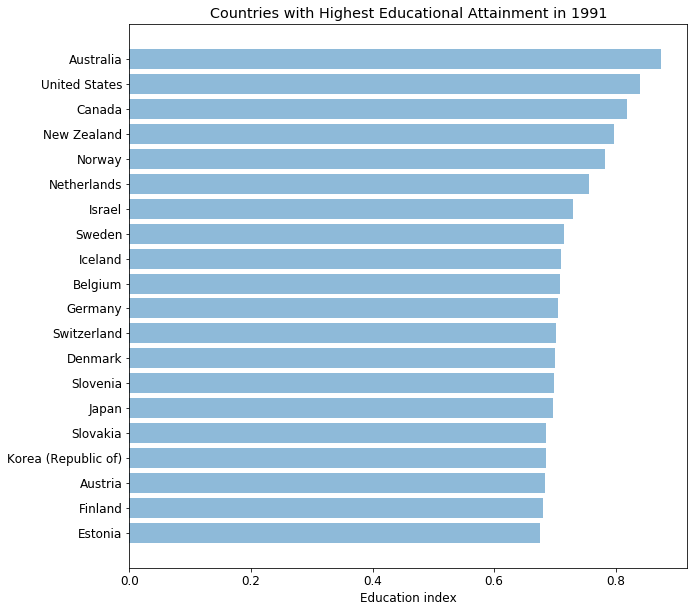

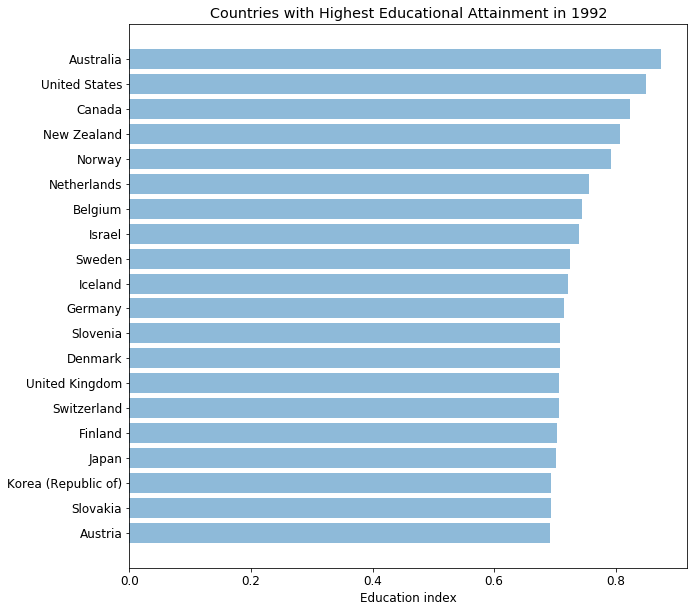

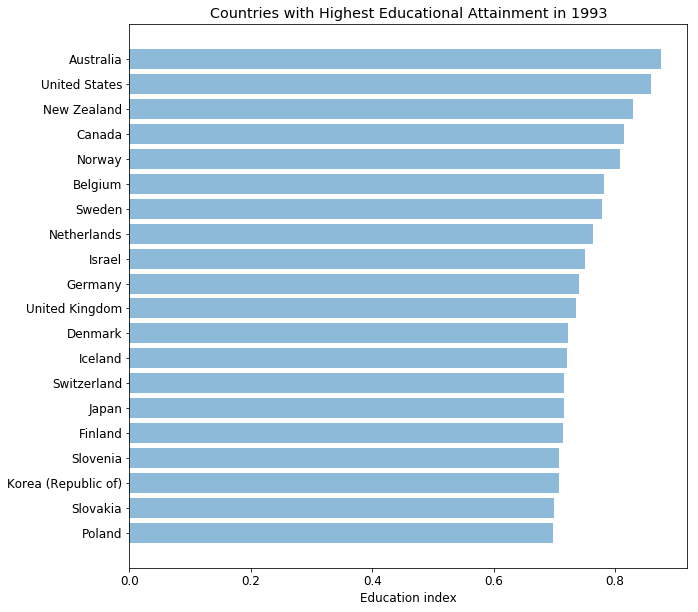

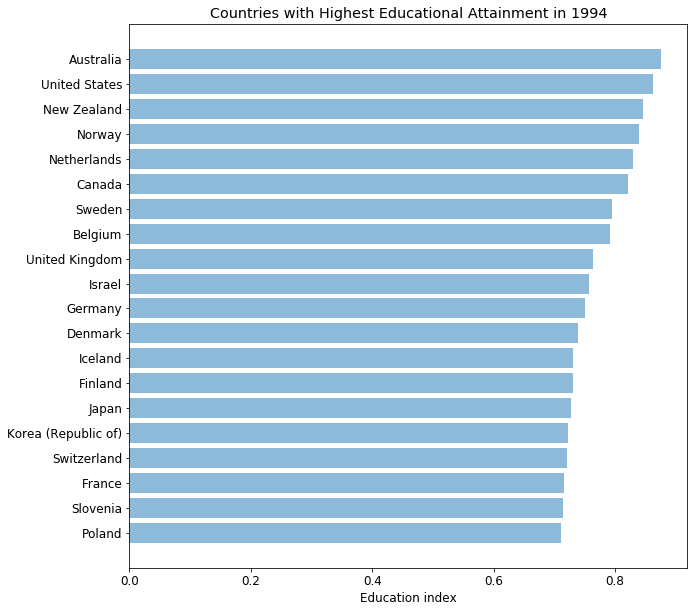

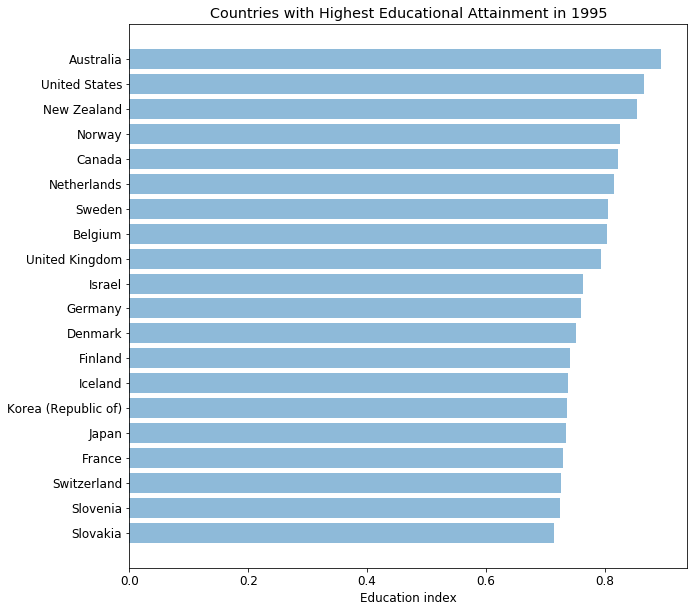

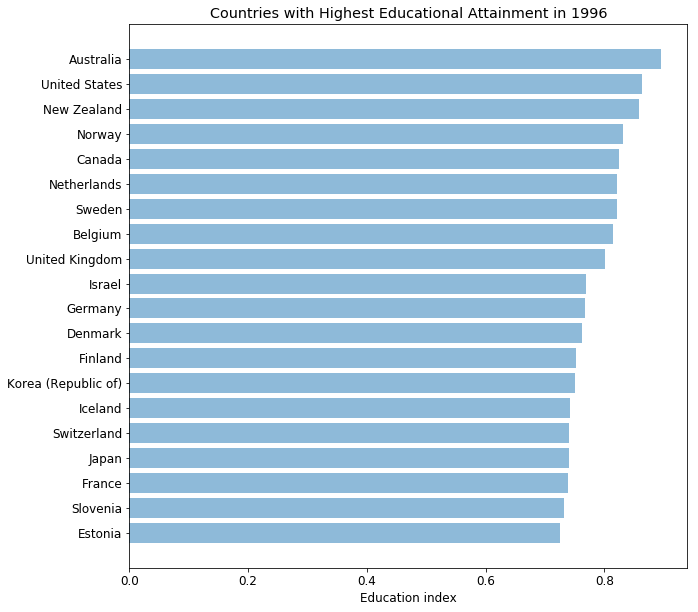

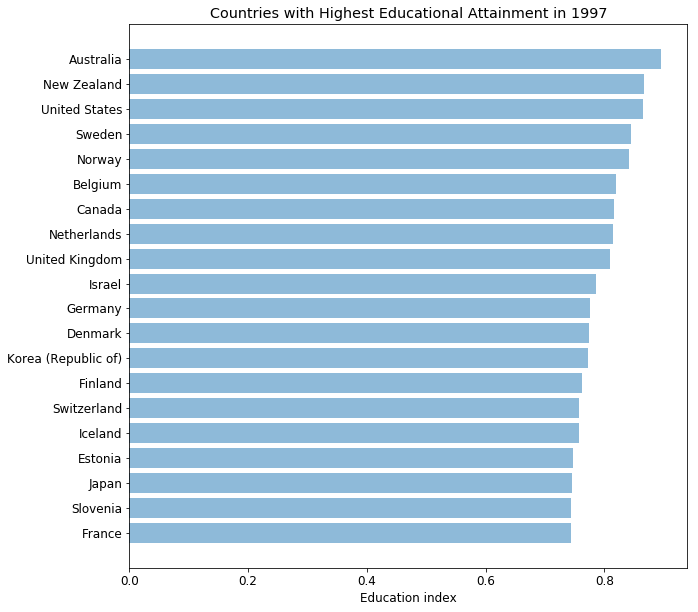

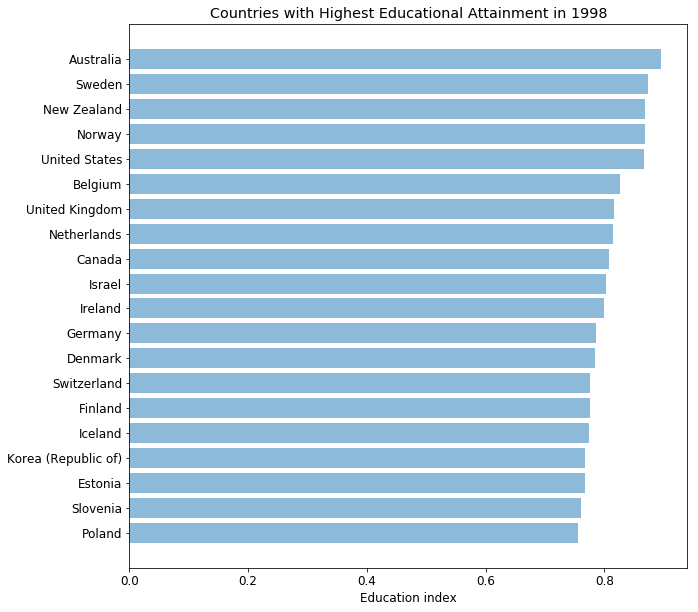

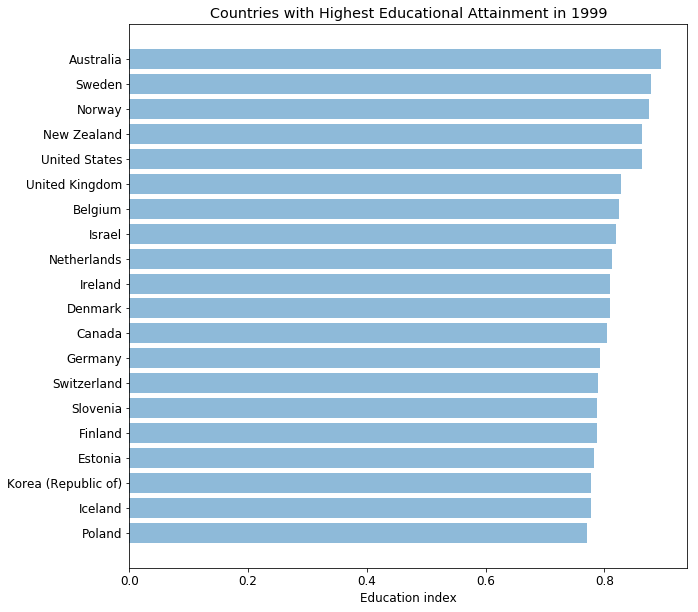

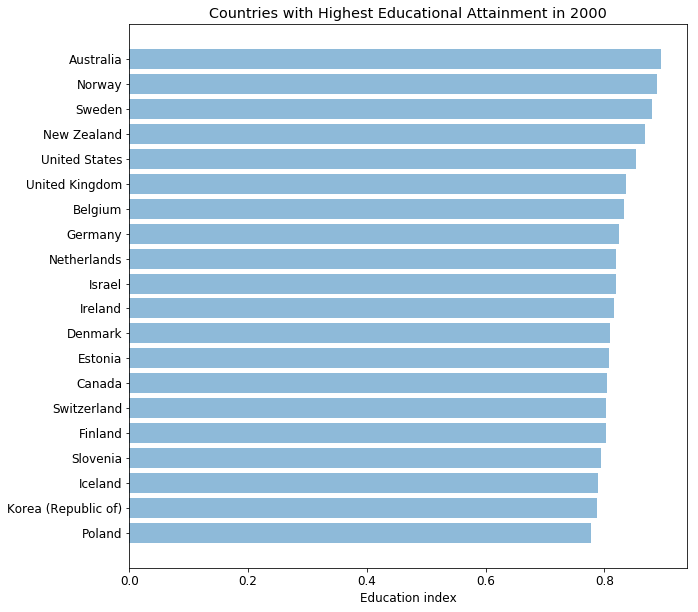

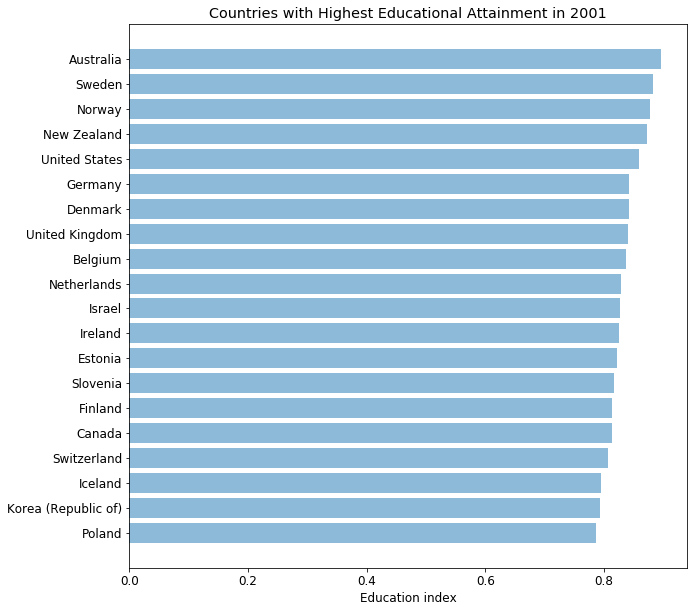

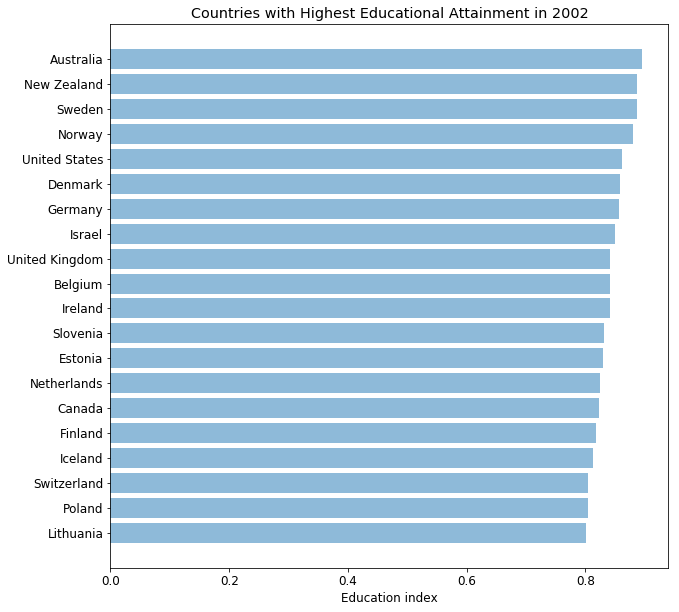

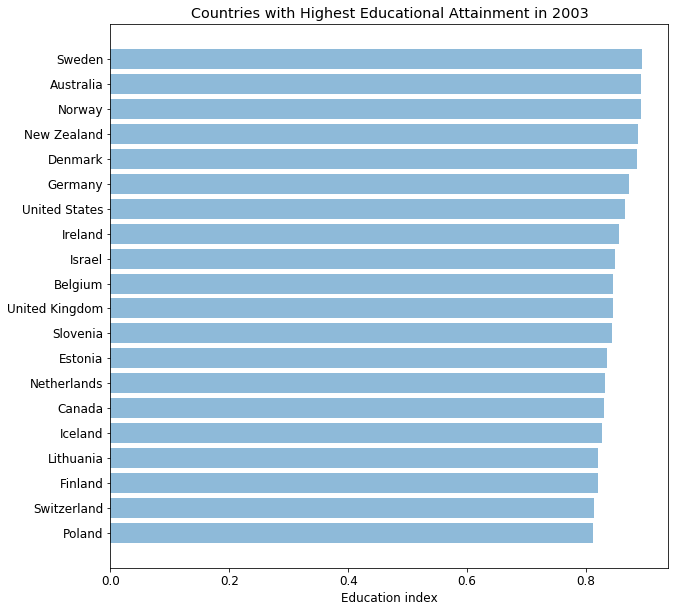

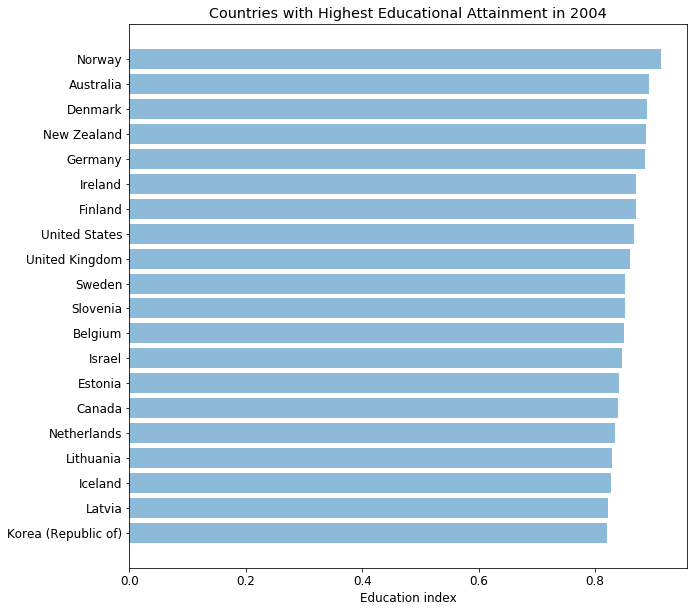

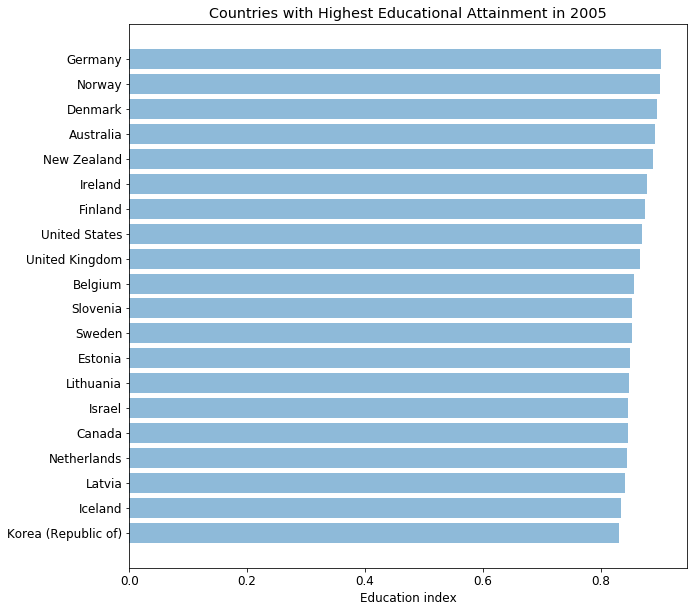

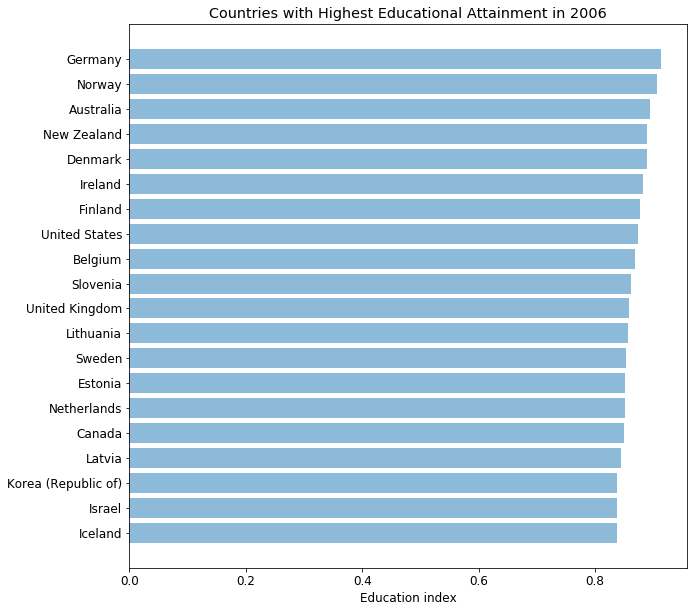

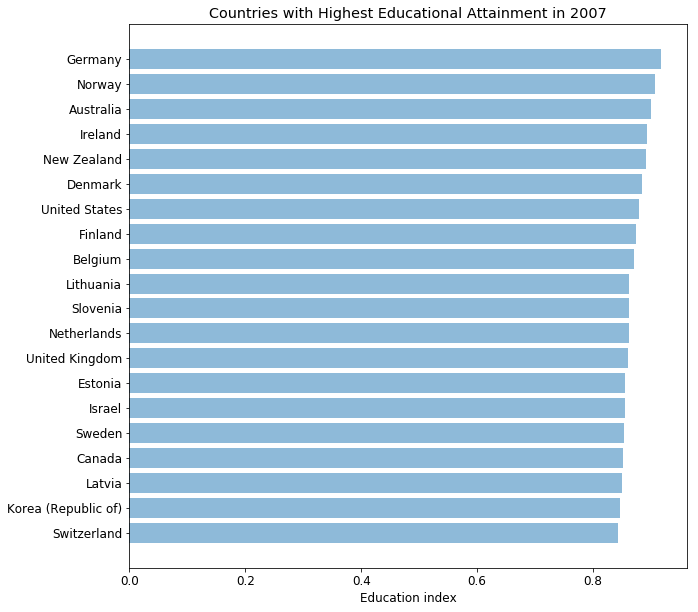

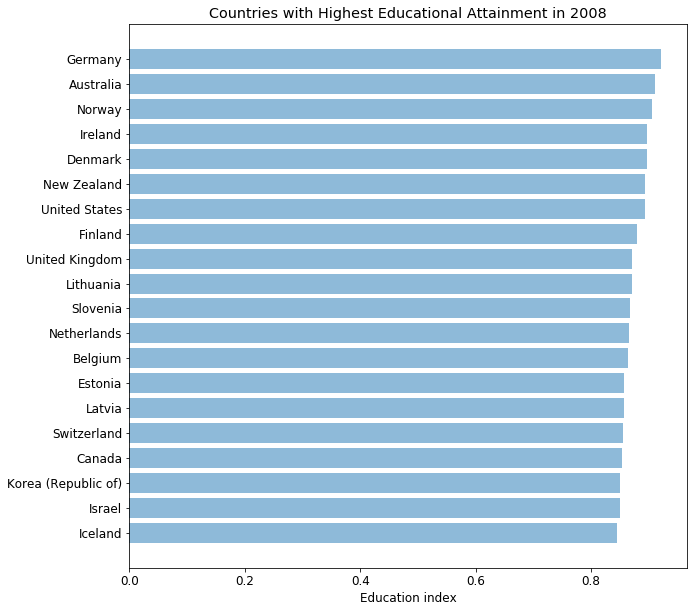

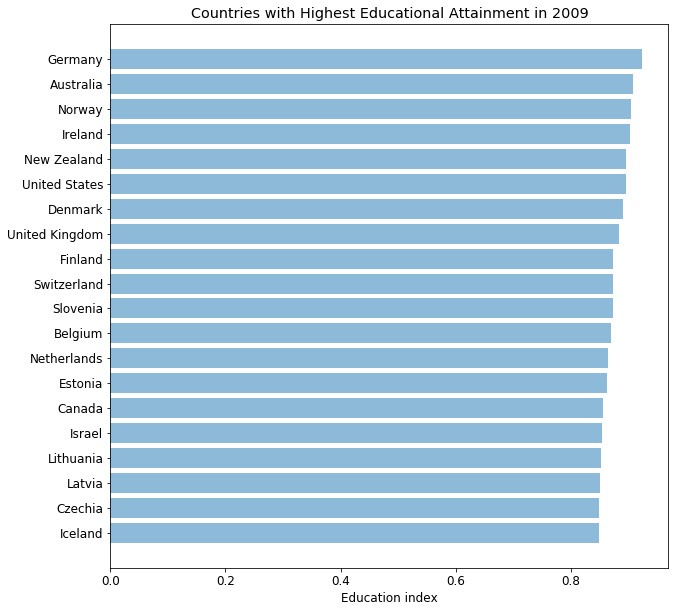

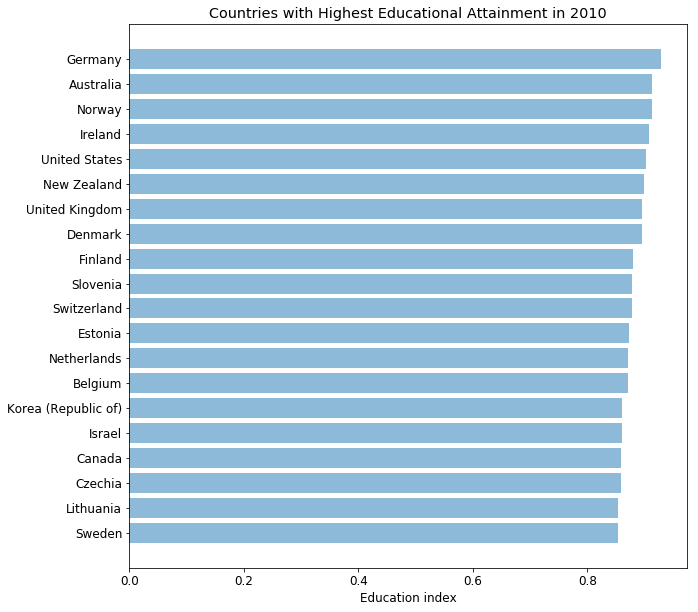

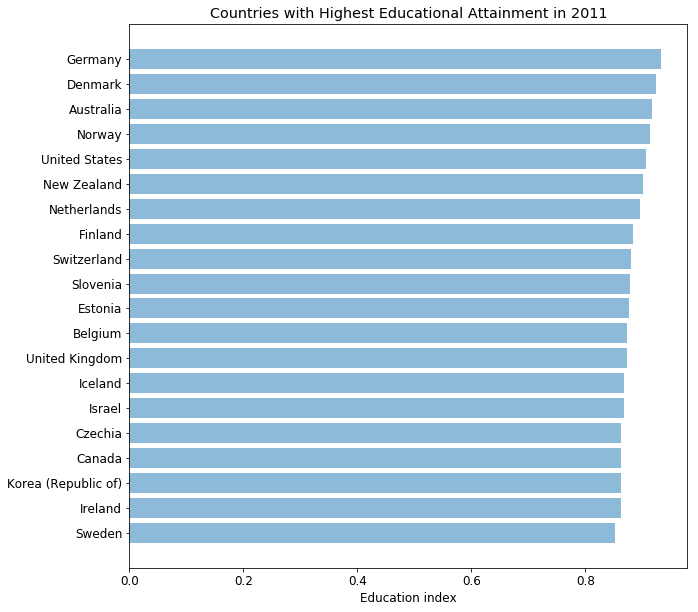

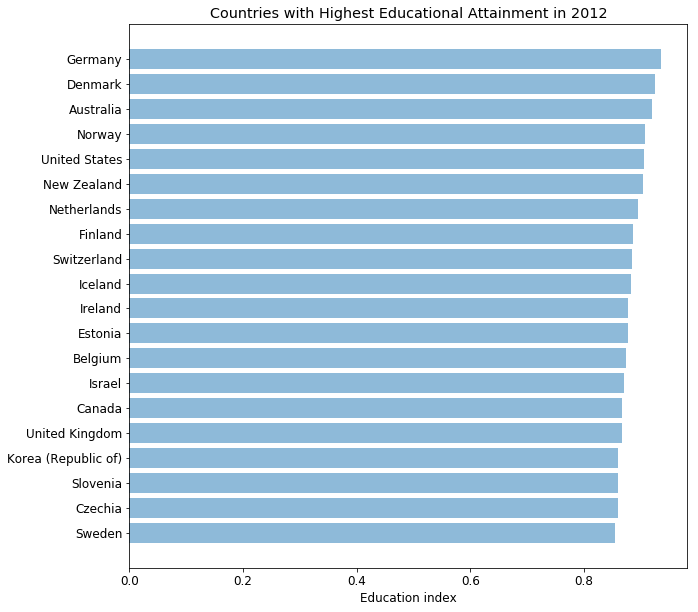

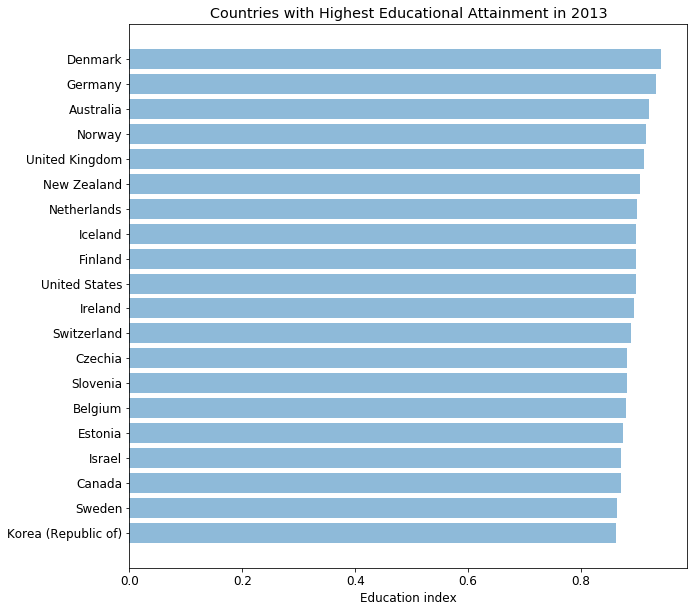

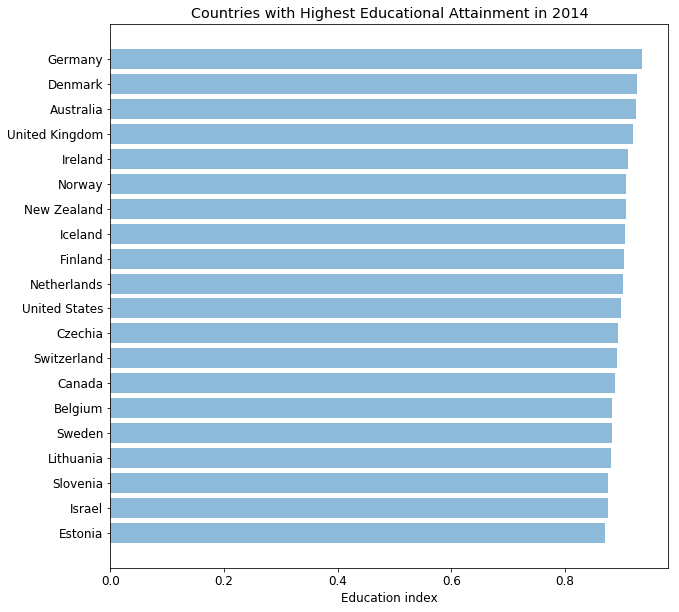

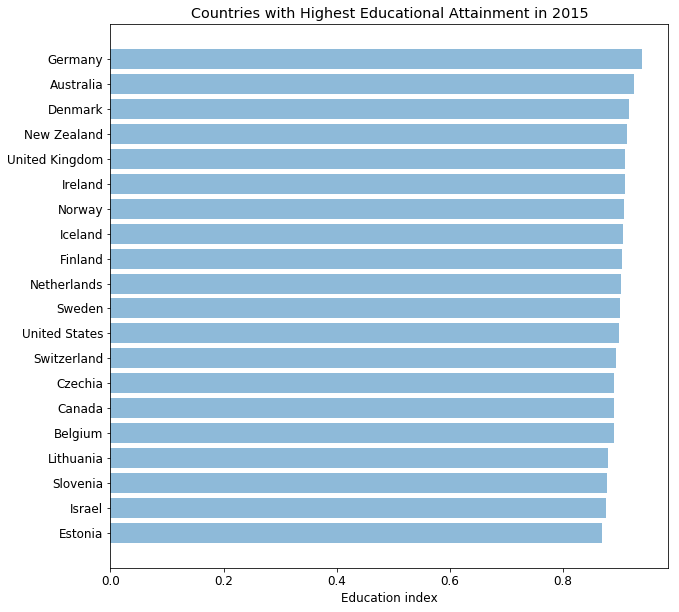

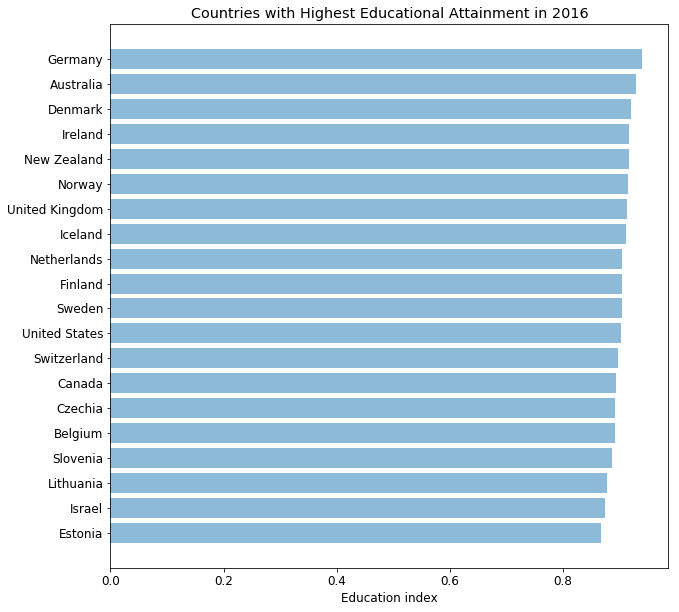

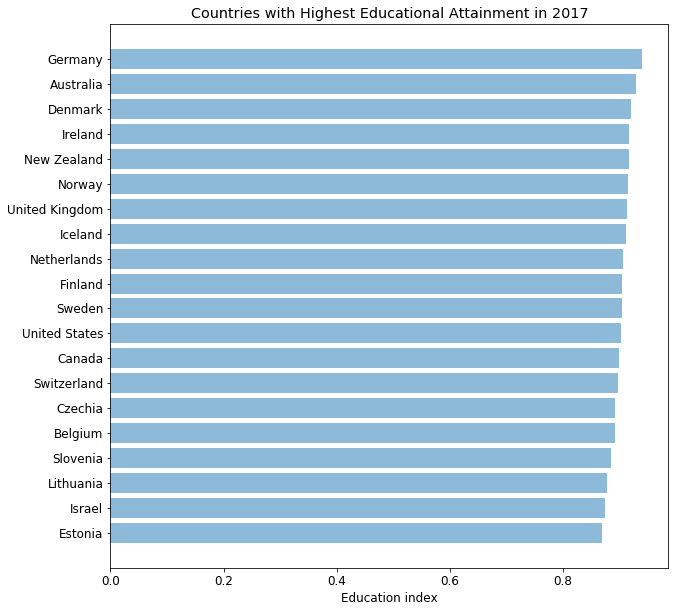

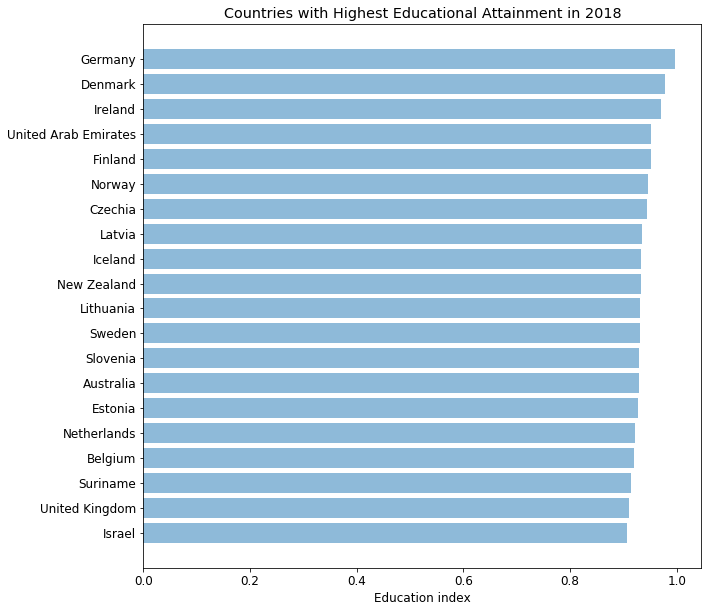

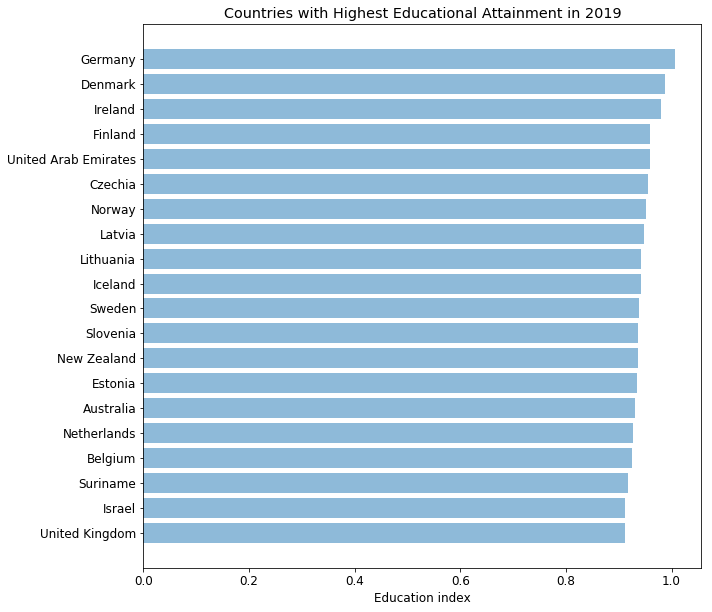

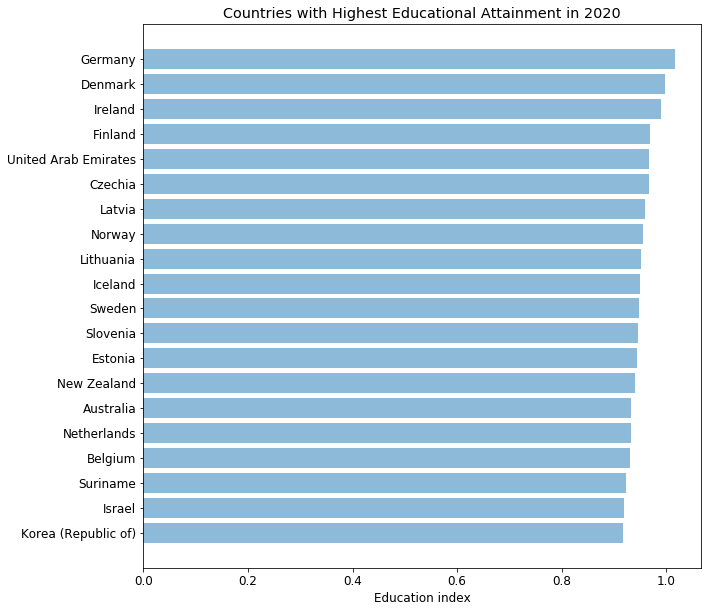

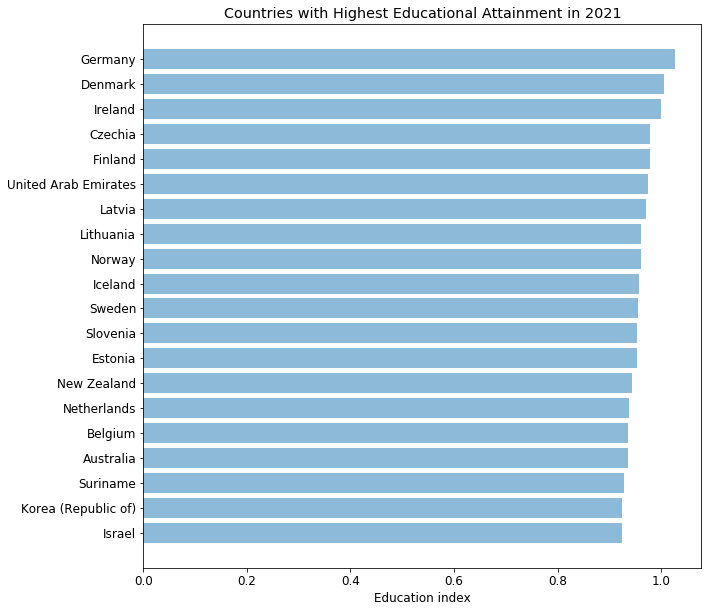

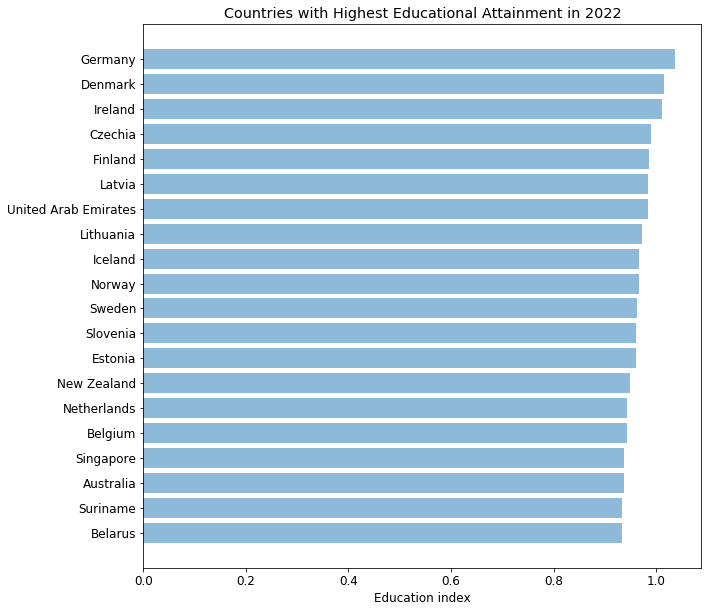

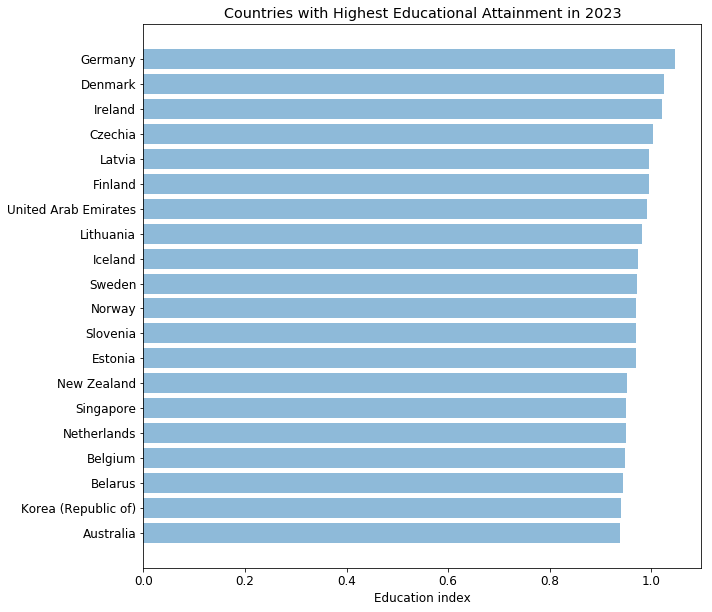

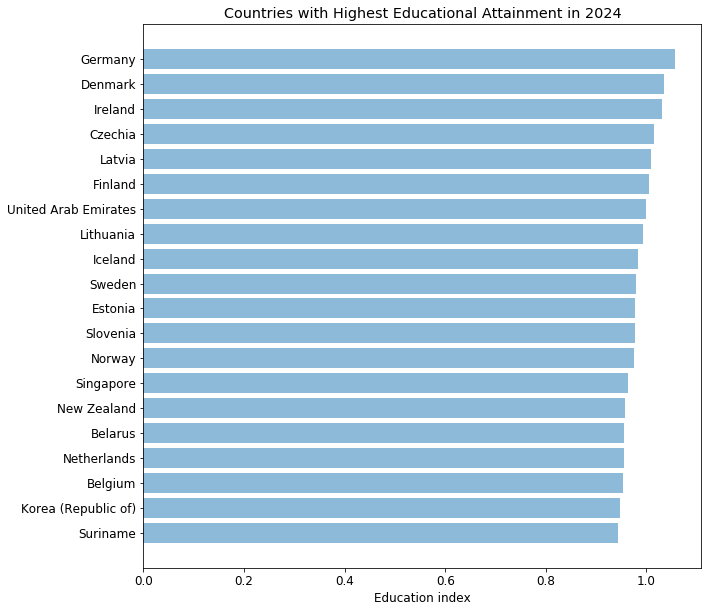

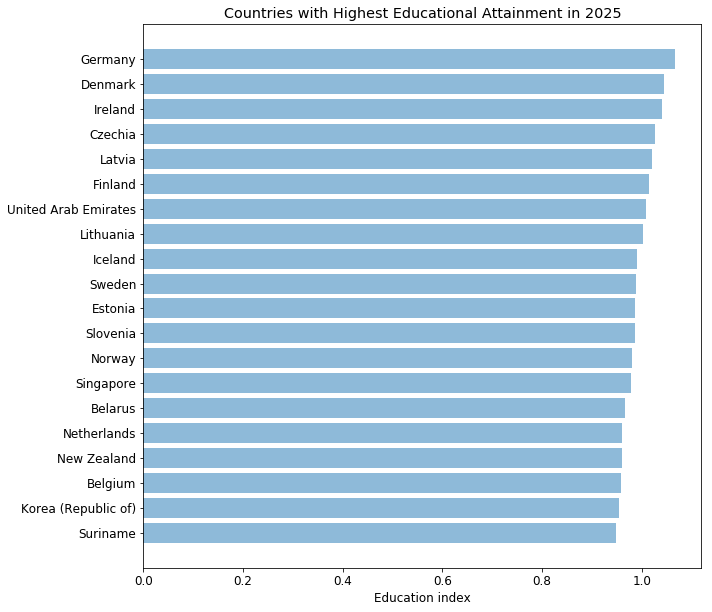

In [42]:
plot_education_index(inds_df)

In [40]:
def prediction_plot(countries, year_start, year_end):
    y_pos = np.arange(len(countries))
    y_val_dict = {}
    for i in range(year_start, year_end + 1):
        y_val_dict[i] = []
    #for country in countries:
    country_amt = 0
    for country in country_indicators:
        eim.fit(inds_df, country, country_indicators[country])
        ret_val = eim.predict_year([year for year in range(year_start, year_end + 1)])
        for year in range(year_start, year_end + 1):
            y_val_dict[year].append(ret_val[year - year_start])
        country_amt += 1
    for year in range(year_start, year_end + 1):
        #edu_idx_list = [[countries[j], y_val_dict[year][j]] for j in range(len(countries))]
        edu_idx_list = [[countries[j], y_val_dict[year][j]] for j in range(country_amt)]
        edu_idx_list.sort(key=lambda x: x[1])
        top_x_vals = []
        top_y_vals = []
        indicator_num = 20
        for j in range(indicator_num):
            top_x_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][0])
            top_y_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][1])
        y_pos = np.arange(len(top_x_vals))
        plt.figure(figsize=(10,10))
        plt.barh(y_pos, top_y_vals, align='center', alpha=0.5)
        plt.yticks(y_pos, top_x_vals)
        plt.xlabel('Education index')
        plt.title("Countries with Highest Educational Attainment in {}".format(year))